In [ ]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 18
NUM_CLASSES = 4
EPOCHS = 80


In [ ]:
# Define paths to your training and testing data
train_data_dir = "/content/drive/My Drive/Dataset_tumor/Training/"
test_data_dir = '/content/drive/My Drive/Dataset_tumor/Testing/'


In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into training/validation
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [ ]:
# Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/80
128/128 [==============================] - 796s 6s/step - loss: 1.0020 - accuracy: 0.5681 - val_loss: 1.1242 - val_accuracy: 0.4852
Epoch 2/80
128/128 [==============================] - 13s 103ms/step - loss: 0.8104 - accuracy: 0.6574 - val_loss: 1.0598 - val_accuracy: 0.5340
Epoch 3/80
128/128 [==============================] - 13s 104ms/step - loss: 0.8095 - accuracy: 0.6683 - val_loss: 1.2311 - val_accuracy: 0.5009
Epoch 4/80
128/128 [==============================] - 14s 108ms/step - loss: 0.7431 - accuracy: 0.6879 - val_loss: 0.9797 - val_accuracy: 0.5881
Epoch 5/80
128/128 [==============================] - 15s 121ms/step - loss: 0.7239 - accuracy: 0.6974 - val_loss: 0.9200 - val_accuracy: 0.5707
Epoch 6/80
128/128 [==============================] - 13s 104ms/step - loss: 0.7182 - accuracy: 0.7053 - val_loss: 0.8860 - val_accuracy: 0.6248
Epoch 7/80
128/128 [==============================] - 13s 103ms/step - loss: 0.6984 - accuracy: 0.7096 - val_loss: 0.9249 - val_accu

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

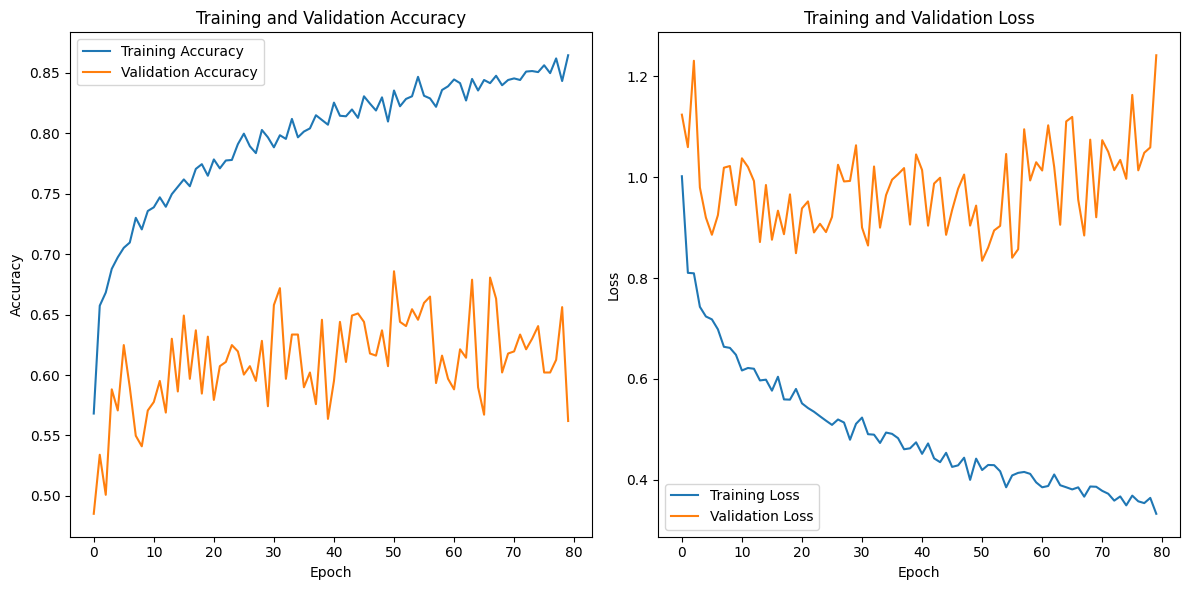

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

In [ ]:

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


In [ ]:
# Get predictions for the test set
Y_pred = model.predict(test_generator)
y_pred = tf.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred))

# Calculate AUC
auc_score = roc_auc_score(y_true, Y_pred, multi_class='ovr')
print(f'AUC Score: {auc_score}')